# Time Series - Part I

- Prepare a dataset on which you can run time series clustering; motif/anomaly discovery and classification.


1. To perform the **clustering** you can choose among different distance functions and clustering algorithms. Remember that you can **reduce the dimensionality through time series approximation**. Analyze the clusters and highlight similarities and differences.


2. Analyze the dataset for **finding motifs and/or anomalies**. Visualize and discuss them and their relationship with other features.


3. Solve the **classification task** on the time series dataset(s) and evaluate each result. In particular, you should use **shapelet-based classifiers** and **structural-based classifiers**. Analyze the shapelets retrieved and discuss if there are any similarities/differences with motifs and/or shapelets.

In [1]:
#### Importing Libraries
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns

### Load Raw Data

There are three main signal types in the raw data: **total acceleration**, **body acceleration**, and **body gyroscope**. Each has 3 axises of data (x, y, z). This means that there are a total of nine variables for each time step.

Further, each series of data has been partitioned into overlapping windows of 2.56 seconds of data, or 128 time steps. These windows of data correspond to the windows of engineered features (rows) in the previous section.

This means that one row of data has (128 * 9), or 1,152 elements. This is a little less than double the size of the 561 element vectors in the previous section and it is likely that there is some redundant data.

Link on how to import the data: https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/

In [2]:
# load dataset
from numpy import dstack
from pandas import read_csv
 
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset(group):
    filepath = group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(group + '/y_'+group+'.txt')
    return X, y
 
# load all train
X_train, y_train = load_dataset('train')
print(X_train.shape, y_train.shape)

# load all test
X_test, y_test = load_dataset('test')
print(X_test.shape, y_test.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


In [3]:
print(len(X_train), 'training series (with 50% overlap between each serie)')
print(len(X_train[0]), 'timesteps per series')
print(len(X_train[0][0]), 'attributes per timestep')

7352 training series (with 50% overlap between each serie)
128 timesteps per series
9 attributes per timestep


In [4]:
# tot_acc_x

X_train = X_train[:,:,0]
X_test  = X_test[:,:,0]  

In [5]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (7352, 128)
X_test shape: (2947, 128)


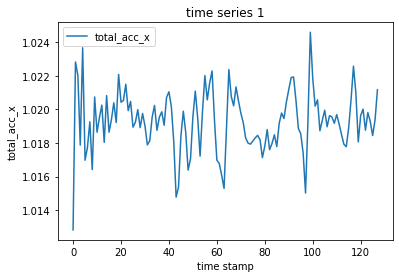

In [6]:
ts1 = X_train[0]
plt.plot(ts1, label='total_acc_x')
plt.title('time series 1')
plt.xlabel('time stamp')
plt.ylabel('total_acc_x')
plt.legend()
plt.show()

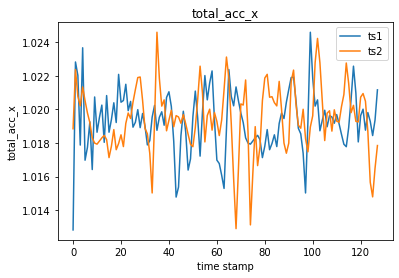

In [7]:
ts1 = X_train[0]
ts2 = X_train[1]
plt.plot(ts1, label='ts1')
plt.plot(ts2, label='ts2')
plt.title('total_acc_x')
plt.xlabel('time stamp')
plt.ylabel('total_acc_x')
plt.legend()
plt.show()

---

## Time series approximation 

### 1. Discrete Fourier Transformation

In [9]:
from pyts.approximation import DiscreteFourierTransform

In [10]:
transformer = DiscreteFourierTransform(n_coefs=12,anova=True)

In [11]:
transformer.get_params(deep=True)

{'anova': True,
 'drop_sum': False,
 'n_coefs': 12,
 'norm_mean': False,
 'norm_std': False}

In [12]:
X_train_new_dft = transformer.fit_transform(X_train, np.ravel(y_train))
X_train_new_dft.shape

(7352, 12)

https://pyts.readthedocs.io/en/stable/auto_examples/approximation/plot_dft.html

In [13]:
def dft_inverse_transform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

In [14]:
X_train_dft_inv = dft_inverse_transform(X_train_new_dft, n_coefs=12, n_timestamps=128)
X_train_dft_inv.shape

(7352, 128)

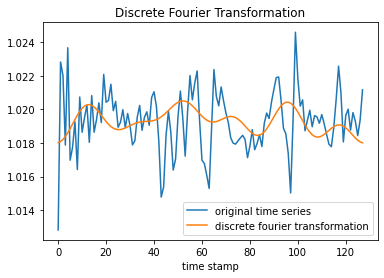

In [15]:
ts1 = X_train[0]
ts2 = X_train_dft_inv[0]
plt.plot(ts1, label='original time series')
plt.plot(ts2, label='discrete fourier transformation')
plt.title('Discrete Fourier Transformation')
plt.xlabel('time stamp')
plt.legend()
plt.show()

### 2. Singular Value Decomposition

In [18]:
from sklearn.decomposition import TruncatedSVD

In [19]:
svd=TruncatedSVD(n_components=12, 
                 random_state=0)

X_train_new_svd = svd.fit_transform(X_train)
X_train_new_svd.shape

(7352, 12)

In [20]:
X_train_svd_inv = svd.inverse_transform(X_train_new_svd)
X_train_svd_inv.shape

(7352, 128)

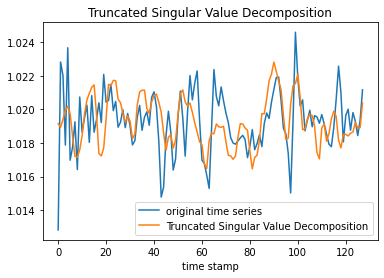

In [21]:
ts1 = X_train[0]
ts2 = X_train_svd_inv[0]
plt.plot(ts1, label='original time series')
plt.plot(ts2, label='Truncated Singular Value Decomposition')
plt.title('Truncated Singular Value Decomposition')
plt.xlabel('time stamp')
plt.legend()
plt.show()

### 3. Piecewise Aggregate Approximation

In [22]:
# Rescale time series
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
X_train_scaled = scaler.fit_transform(X_train)

In [23]:
from tslearn.piecewise import PiecewiseAggregateApproximation

In [24]:
# PAA transform (and inverse transform) of the data
paa = PiecewiseAggregateApproximation(n_segments=12)
X_train_new_paa = paa.fit_transform(X_train_scaled)
X_train_new_paa.shape

(7352, 12, 1)

In [25]:
X_train_paa_inv = paa.inverse_transform(X_train_new_paa)
X_train_paa_inv.shape

(7352, 128, 1)

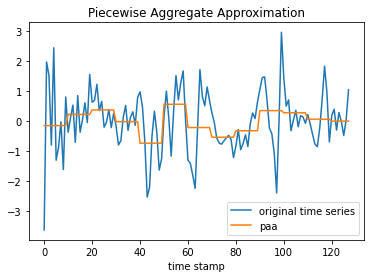

In [26]:
ts1 = X_train_scaled[0]
ts2 = X_train_paa_inv[0]
plt.plot(ts1, label='original time series')
plt.plot(ts2, label='paa')
plt.title('Piecewise Aggregate Approximation')
plt.xlabel('time stamp')
plt.legend()
plt.show()

### 4. Symbolic Aggregate Approximation

In [27]:
from tslearn.piecewise import SymbolicAggregateApproximation

In [29]:
# SAX transform
sax = SymbolicAggregateApproximation(n_segments=12, alphabet_size_avg=8)
X_train_new_sax = sax.fit_transform(X_train_scaled)
X_train_new_sax.shape

(7352, 12, 1)

In [30]:
X_train_sax_inv = sax.inverse_transform(X_train_new_sax)
X_train_sax_inv.shape

(7352, 128, 1)

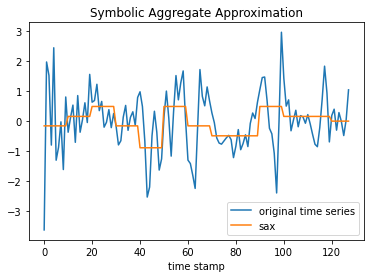

In [31]:
ts1 = X_train_scaled[0]
ts2 = X_train_sax_inv[0]
plt.plot(ts1, label='original time series')
plt.plot(ts2, label='sax')
plt.title('Symbolic Aggregate Approximation')
plt.xlabel('time stamp')
plt.legend()
plt.show()

----

# 2. Clustering 

Approximation used is **Singular value decomposition**

**Class Labels**

1:'WALKING', 
2:'W_UPSTAIRS', 
3:'W_DOWNSTAIRS', 
4:'SITTING', 
5:'STANDING', 
6:'LAYING'

## 1. Partitional Clustering 

### 1.1 TimeSeries KMeans

In [32]:
from tslearn.clustering import TimeSeriesKMeans
from collections import Counter
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, contingency_matrix

In [62]:
### KMeans with softdtw distance
km = TimeSeriesKMeans(n_clusters=6, 
                      metric="softdtw", 
                      max_iter=5, 
                      max_iter_barycenter=20,
                      random_state=0)

km.fit(X_train_new_sax)

TimeSeriesKMeans(max_iter=5, max_iter_barycenter=20, metric='softdtw',
                 n_clusters=6, random_state=0)

In [63]:
print('kMeans labels %s' % Counter(km.labels_+1))

kMeans labels Counter({4: 1721, 3: 1675, 1: 1652, 2: 932, 5: 837, 6: 535})


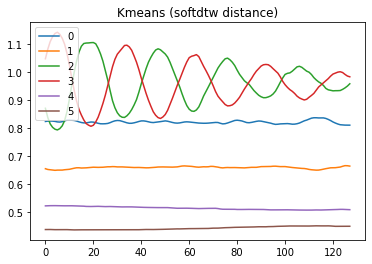

In [64]:
for i in range(6):
    plt.plot(np.mean(X_train[np.where(km.labels_ == i)[0]], axis=0), label=i)
plt.legend()
plt.title("Kmeans (softdtw distance)")
plt.show()

In [65]:
# homogeneity_score, completeness_score, v_measure_score

print("Homogeneity: %0.3f" % homogeneity_score(np.squeeze(y_train), km.labels_))
print("Completeness: %0.3f" % completeness_score(np.squeeze(y_train), km.labels_))
print("V-measure: %0.3f" % v_measure_score(np.squeeze(y_train), km.labels_))

Homogeneity: 0.279
Completeness: 0.290
V-measure: 0.284


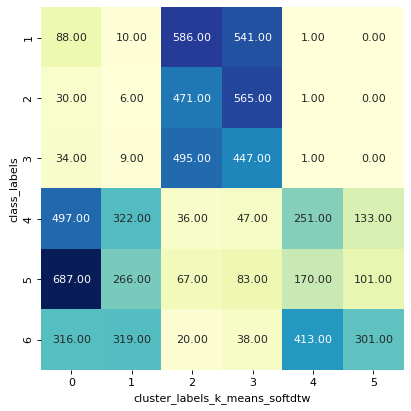

In [66]:
## Contingency Matrix
df = pd.DataFrame()
df['cluster_labels_k_means_softdtw'] = km.labels_
df['class_labels'] = y_train

contingency_matrix = pd.crosstab(df['cluster_labels_k_means_softdtw'], df['class_labels'])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sns.heatmap(contingency_matrix.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)

plt.show()

In [38]:
### KMeans with euclidean distance
km = TimeSeriesKMeans(n_clusters=6, 
                      metric="euclidean", 
                      max_iter=5, 
                      max_iter_barycenter=20,
                      random_state=0)

km.fit(X_train_new_sax)

TimeSeriesKMeans(max_iter=5, max_iter_barycenter=20, n_clusters=6,
                 random_state=0)

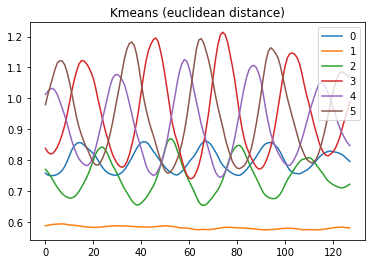

In [39]:
for i in range(6):
    plt.plot(np.mean(X_train[np.where(km.labels_ == i)[0]], axis=0), label=i)
plt.legend()
plt.title("Kmeans (euclidean distance)")
plt.show()

In [40]:
print('kMeans labels %s' % Counter(km.labels_+1))

kMeans labels Counter({1: 1618, 3: 1535, 2: 1295, 5: 1099, 4: 970, 6: 835})


In [41]:
# homogeneity_score, completeness_score, v_measure_score

print("Homogeneity: %0.3f" % homogeneity_score(np.squeeze(y_train), km.labels_))
print("Completeness: %0.3f" % completeness_score(np.squeeze(y_train), km.labels_))
print("V-measure: %0.3f" % v_measure_score(np.squeeze(y_train), km.labels_))

Homogeneity: 0.133
Completeness: 0.134
V-measure: 0.134


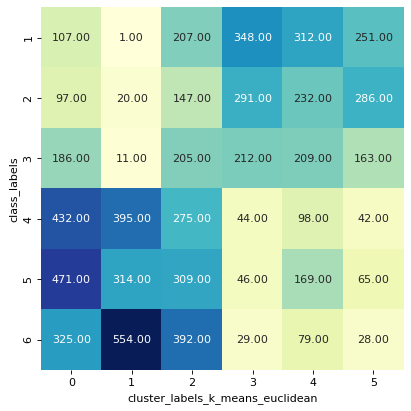

In [42]:
## Contingency Matrix

df['cluster_labels_k_means_euclidean'] = km.labels_

contingency_matrix = pd.crosstab(df['cluster_labels_k_means_euclidean'], df['class_labels'])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sns.heatmap(contingency_matrix.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)

plt.show()

## 2. Time Series Hierarchical Clustering

#### sklearn agglomerative clustering

https://towardsdatascience.com/how-to-apply-hierarchical-clustering-to-time-series-a5fe2a7d8447

In [43]:
from imblearn.under_sampling import RandomUnderSampler 

from pyts.metrics import dtw
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from tqdm import tqdm

from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram

In [45]:
len(X_train_new_sax)

7352

In [47]:
# Initialize distance matrix
n_series = len(X_train_new_sax)
distance_matrix = np.zeros(shape=(n_series, n_series))

In [51]:
X_train_new_sax = np.squeeze(X_train_new_sax)
X_train_new_sax.shape

(7352, 12)

In [52]:
# Build distance matrix
for i in tqdm(range(n_series)):
    for j in range(n_series):
        x = X_train_new_sax[i]
        y = X_train_new_sax[j]
        if i < j:
            dist = dtw(x, y, dist='square', method='sakoechiba', options={'window_size': 0.1})
            distance_matrix[i,j] , distance_matrix[j,i] = dist , dist

100%|██████████| 7352/7352 [3:01:02<00:00,  1.48s/it]     


In [53]:
clustering = AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters = 6).fit_predict(distance_matrix)

In [54]:
np.unique(clustering)

array([0, 1, 2, 3, 4, 5])

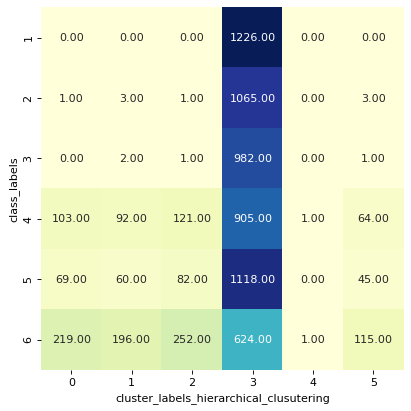

In [55]:
## Contingency Matrix

df['cluster_labels_hierarchical_clusutering'] = clustering

contingency_matrix = pd.crosstab(df['cluster_labels_hierarchical_clusutering'], df['class_labels'])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sns.heatmap(contingency_matrix.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)

plt.show()

In [56]:
%time 
Z = average(distance_matrix)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


/Users/riccardo/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:446: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='average', metric='euclidean')


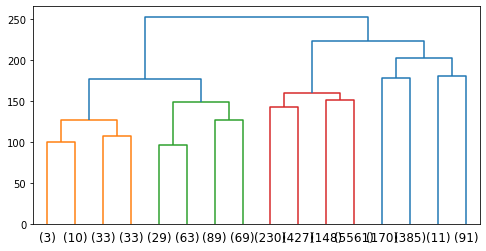

In [57]:
fig = plt.figure(figsize=(8, 4))
d = dendrogram(Z, p=3, truncate_mode='level')
plt.show()

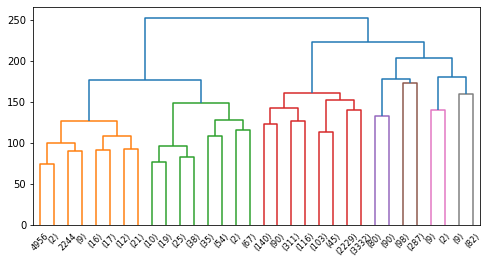

In [58]:
fig = plt.figure(figsize=(8, 4))
d = dendrogram(Z, p=4, truncate_mode='level')
plt.show()

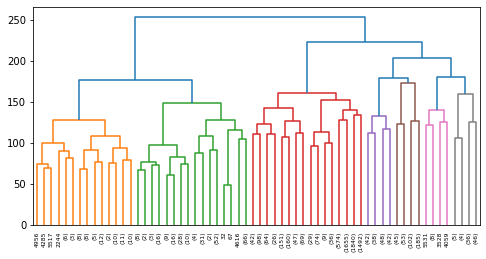

In [59]:
fig = plt.figure(figsize=(8, 4))
d = dendrogram(Z, p=5, truncate_mode='level')
plt.show()

#### scipy agglomerative clustering

In [60]:
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(Z, 6 , criterion='maxclust')
print(np.unique(cluster_labels))

[1 2 3 4 5 6]


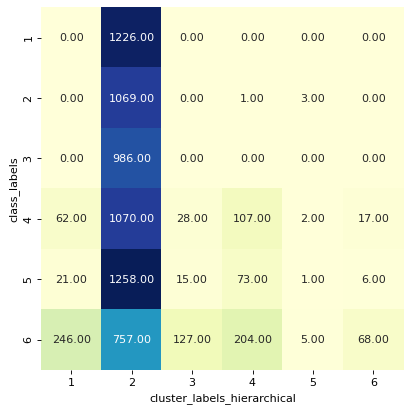

In [61]:
#Contingency Matrix

df['cluster_labels_hierarchical'] = cluster_labels

contingency_matrix = pd.crosstab(df['cluster_labels_hierarchical'], df['class_labels'])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sns.heatmap(contingency_matrix.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)

plt.show()

## 3. Features Based Clustering

----

## Matrix Profile STUMPY

https://stumpy.readthedocs.io/en/latest/Tutorial_Fast_Approximate_Matrix_Profiles.html

## Matrix Profile matrixprofile_ts

https://github.com/target/matrixprofile-ts

In [58]:
from matrixprofile import *

In [61]:
df_train = pd.DataFrame(X_train)

In [62]:
w = 12
mp, mpi = matrixProfile.stomp(df_train.values[0], w)

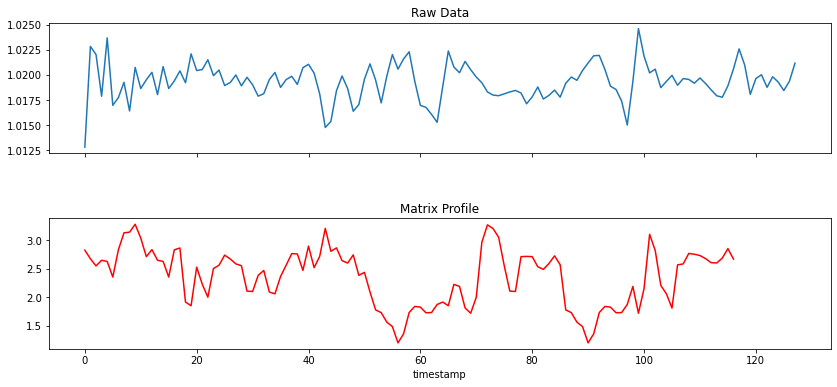

In [63]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(14,6))
fig.subplots_adjust(hspace=0.5)

#Plot the signal data
ax1.plot(df_train.values[0])
ax1.set_title('Raw Data')

#Plot the Matrix Profile
ax2.plot(mp, c='r')
ax2.set_title('Matrix Profile')
ax2.set_xlabel('timestamp')

plt.show()

## Motifs Discovery

In [64]:
pattern = df_train.values[0]

m=12
profile = matrixProfile.stomp(pattern,m)

mtfs ,motif_d  = motifs.motifs(pattern, profile, max_motifs=5)

In [65]:
def plot_motifs(mtfs, labels):

    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + m,len(pattern)-1) for s in starts]
        plt.plot(starts, pattern[starts],  c +'o',  label=l)
        plt.plot(ends, pattern[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            plt.plot(range(nn,nn+m),pattern[nn:nn+m], c , linewidth=2)
        colori += 1

    plt.plot(pattern, 'k', linewidth=1, label="data")
    plt.title('Top {} Motifs'.format(colori))
    plt.legend()

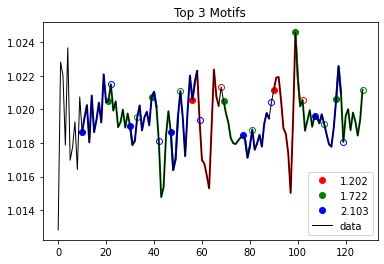

In [66]:
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d])

## Anomalies Discovery

In [67]:
df

,cluster_labels_k_means_softdtw,class_labels,cluster_labels_k_means_euclidean,cluster_labels_hierarchical_clusutering,cluster_labels_hierarchical
0,0,5,2,4,3
1,0,5,2,4,3
2,0,5,2,4,3
3,0,5,2,4,3
4,0,5,2,4,3
...,...,...,...,...,...
7347,0,2,2,4,3
7348,0,2,5,4,3
7349,0,2,5,4,3
7350,0,2,5,4,3


## Matrix Profile, Motifs & Anomalies Discovery on Clusters Centroids

In [67]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.cluster import contingency_matrix

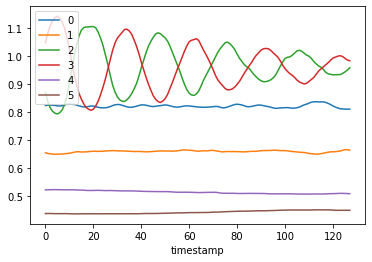

In [70]:
# Plotting the centroids
for i in range(6):
    plt.plot(np.mean(X_train[np.where(km.labels_ == i)], axis=0), label=i) 
    
plt.legend()
#plt.title("Centroids")
plt.xlabel('timestamp')
plt.show()

In [71]:
# Centroids of clustering
cluster_0 = np.mean(X_train[np.where(km.labels_ == 0)], axis=0)
cluster_1 = np.mean(X_train[np.where(km.labels_ == 1)], axis=0)
cluster_2 = np.mean(X_train[np.where(km.labels_ == 2)], axis=0)
cluster_3 = np.mean(X_train[np.where(km.labels_ == 3)], axis=0)
cluster_4 = np.mean(X_train[np.where(km.labels_ == 4)], axis=0)
cluster_5 = np.mean(X_train[np.where(km.labels_ == 5)], axis=0)

### Matrix Profile

In [72]:
from matrixprofile import *

In [73]:
w = 12
mp_0, mpi_0 = matrixProfile.stomp(cluster_0, w)

In [74]:
w = 12
mp_1, mpi_1 = matrixProfile.stomp(cluster_1, w)

In [75]:
w = 12
mp_2, mpi_2 = matrixProfile.stomp(cluster_2, w)

In [76]:
w = 12
mp_3, mpi_3 = matrixProfile.stomp(cluster_3, w)

In [77]:
w = 12
mp_4, mpi_4 = matrixProfile.stomp(cluster_4, w)

In [78]:
w = 12
mp_5, mpi_5 = matrixProfile.stomp(cluster_5, w)

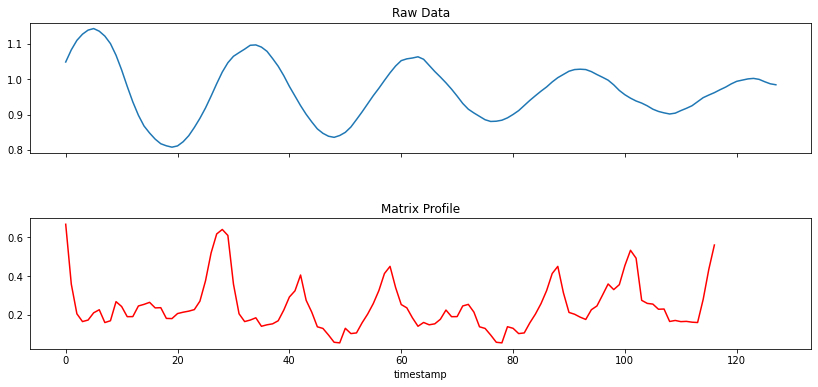

In [79]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(14,6))
fig.subplots_adjust(hspace=0.5)

#Plot cluster centroids 3
ax1.plot(cluster_3)
ax1.set_title('Raw Data')

#Plot the Matrix Profile 
ax2.plot(mp_3, c='r')
ax2.set_title('Matrix Profile')
ax2.set_xlabel('timestamp')

plt.show()

### Motifs Discovery

In [81]:
mtfs_2 ,motif_d_2  = motifs.motifs(cluster_2, (mp_2, mpi_2) , max_motifs=3)

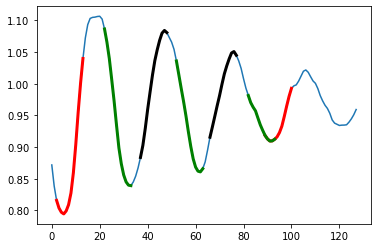

In [82]:
plt.plot(cluster_2)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mtfs_2 )]
for m, d, c in zip(mtfs_2 , motif_d_2, colors):
    for i in m:
        m_shape = cluster_2[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

In [84]:
mtfs_3 ,motif_d_3  = motifs.motifs(cluster_3, (mp_3, mpi_3) , max_motifs=3)

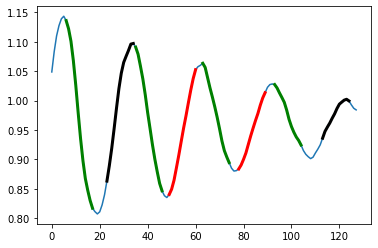

In [85]:
plt.plot(cluster_3)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mtfs_3)]
for m, d, c in zip(mtfs_3 , motif_d_3, colors):
    for i in m:
        m_shape = cluster_3[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

### Anomalies Discovery

In [87]:
from matrixprofile.discords import discords

In [88]:
anoms_2 = discords(mp_2, ex_zone=3, k=3)

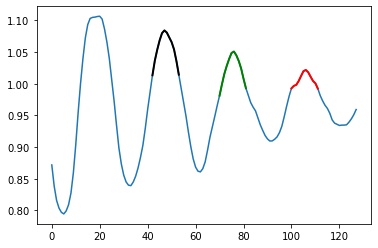

In [89]:
plt.plot(cluster_2)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mtfs_2)]
for a, c in zip(anoms_2, colors):
    a_shape = cluster_2[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=2)

plt.show()

In [91]:
anoms_3 = discords(mp_3, ex_zone=3, k=3)

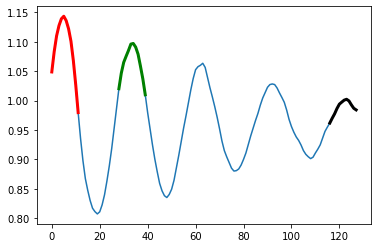

In [92]:
plt.plot(cluster_3)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mtfs_3)]
for a, c in zip(anoms_3, colors):
    a_shape = cluster_3[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

## Concatenation of centroids of cluster c

In [43]:
c = np.concatenate((cluster_3 ,cluster_4 ,cluster_5 ))
c.shape

In [47]:
w = 12
mp_c, mpi_c = matrixProfile.stomp(c, w)

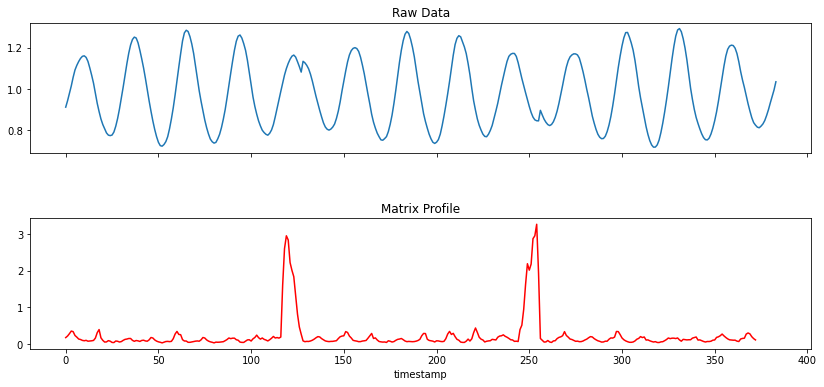

In [48]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(14,6))
fig.subplots_adjust(hspace=0.5)

#Plot cluster centroids 3
ax1.plot(c)
ax1.set_title('Raw Data')

#Plot the Matrix Profile 
ax2.plot(mp_c, c='r')
ax2.set_title('Matrix Profile')
ax2.set_xlabel('timestamp')

plt.show()

In [50]:
mtfs_c ,motif_d_c  = motifs.motifs(c, (mp_c, mpi_c) , max_motifs=5)

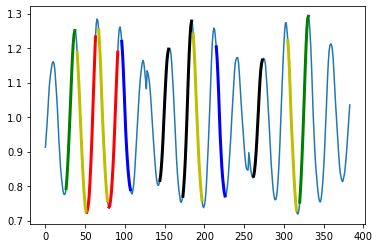

In [51]:
plt.plot(c)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mtfs_c )]
for m, d, k in zip(mtfs_c , motif_d_c, colors):
    for i in m:
        m_shape = c[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=k, lw=3)

plt.show()

In [54]:
anoms_c = discords(mp_c, ex_zone=3, k=5)

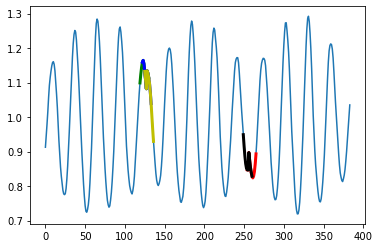

In [56]:
plt.plot(c)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mtfs_c)]
for a, k in zip(anoms_c, colors):
    a_shape = c[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=k, lw=3)

plt.show()